# wide-deep模型架构

**wide-deep**模型是业界点击率预估最常用的模型，这个模型的参数主要由两部分组成：
1. sparse参数。
    在下图中由`Sparse Features`标识的区域全部为sparse特征。
2. dense参数。
    除了sparse的特征之外，都可以视作dense的特征。
    
一般的，在真实场景中`Sparse Features`中包含几十或几百个`feature`（下图`Sparse Features`部分每一个圆圈即为一个`feature`），比如`广告id`、`用户id`、`用户所在的城市`等等都属于一个`feature`，通常每个`feature`对应不同的维度，从几十到几亿不等，比如`用户id`往往会大于一亿维（有一亿个用户），`用户所在的城市`不到1000维。当`feature`比较多的时候要从这些高维的`feature`中获取参数成了训练这种模型的极大挑战。

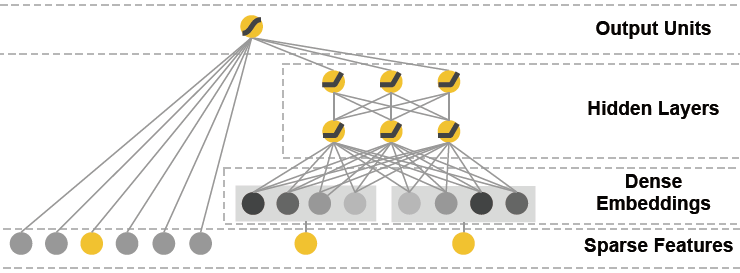

## slot

在TensorNet中将上面模型中的`feature`统一抽象称为`slot`，每一个`feature`即为一个`slot`，但构造复杂模型的时候每个`slot`可以不局限为一个`feature`。

## sign

对于每个`feature`的每个维度可以用一个字符串或数字表示，比如`城市`有`北京`、`天津`等等，每一个`广告id`都是一个int64的值。TensorNet要求这些值要全部哈希成一个uint64的值，我们称之为`sign`。

## TensorFlow原生版的wide-deep模型

In [1]:
import tensorflow as tf
TEST_DATA_PATH = '/tmp/wide-deep-test/'
!mkdir $TEST_DATA_PATH

mkdir: cannot create directory `/tmp/wide-deep-test/': File exists


### 生成测试数据

下面脚本生成两个`part`的数据，每个`part`有12000个样本，每个样本都有4个`feature`。每个`feature`维度为65536维

In [2]:
import random

def serialize_example(slots):
    fea_desc = {}

    label = random.choice([1, 0])
    fea_desc["label"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))

    for slot in slots:
        values = [random.randint(1, 2**16)]
        fea_desc[slot] = tf.train.Feature(int64_list=tf.train.Int64List(value=values))

    example_proto = tf.train.Example(features=tf.train.Features(feature=fea_desc))

    return example_proto.SerializeToString()

def generate_data(name):
    slots = ["1", "2", "3", "4"]
    count = 12000

    with tf.io.TFRecordWriter(TEST_DATA_PATH + "/tf-part.%s" % name) as writer:
        for i in range(count):
            example = serialize_example(slots)
            writer.write(example)

generate_data('00001')
generate_data('00002')

In [47]:
!ls -l $TEST_DATA_PATH

total 2088
-rw-rw-r-- 1 zhangyansheng zhangyansheng 1067980 Aug 21 19:00 tf-part.00001
-rw-rw-r-- 1 zhangyansheng zhangyansheng 1067857 Aug 21 19:00 tf-part.00002


### 编写模型 

In [3]:
class Config(object):
    FILE_MATCH_PATTERN = "tf-*"
    BATCH_SIZE = 32
    DEEP_HIDDEN_UNITS = [512, 256, 256]

    WIDE_SLOTS = [ "1","2","3","4"]
    DEEP_SLOTS = [ "1","2","3","4"]
    
C = Config

下面代码通过TensorFlow的dataset读取数据。

In [4]:
import os

def parse_line_batch(example_proto):
    fea_desc = {
        "label": tf.io.FixedLenFeature([], tf.int64)
    }

    for slot in set(C.WIDE_SLOTS + C.DEEP_SLOTS):
        fea_desc[slot]  = tf.io.VarLenFeature(tf.int64)

    feature_dict = tf.io.parse_example(example_proto, fea_desc)

    label = feature_dict.pop('label')
    return feature_dict, label

def read_dataset(data_path, match_pattern):
    data_file = os.path.join(data_path, match_pattern)
    dataset = tf.data.Dataset.list_files(data_file)

    dataset = dataset.interleave(lambda f: tf.data.TFRecordDataset(f, buffer_size=1024 * 100))
    dataset = dataset.batch(C.BATCH_SIZE)
    dataset = dataset.map(map_func=parse_line_batch)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

下面代码使用TensorFlow的feature_column构造模型，wide部分每个`feature`的`embedding_size`为1，deep部分每个`feature`的`embedding_size`为8。

In [5]:
def columns_builder():
    column_1 = tf.feature_column.categorical_column_with_hash_bucket(
      '1', hash_bucket_size = 2**16, dtype=tf.int64)
    column_2 = tf.feature_column.categorical_column_with_hash_bucket(
      '2', hash_bucket_size = 2**16, dtype=tf.int64)
    column_3 = tf.feature_column.categorical_column_with_hash_bucket(
      '3', hash_bucket_size = 2**16, dtype=tf.int64)
    column_4 = tf.feature_column.categorical_column_with_hash_bucket(
      '4', hash_bucket_size = 2**16, dtype=tf.int64)
    
    wide_columns = [
        tf.feature_column.embedding_column(column_1, dimension=1),
        tf.feature_column.embedding_column(column_2, dimension=1),
        tf.feature_column.embedding_column(column_3, dimension=1),
        tf.feature_column.embedding_column(column_4, dimension=1),
    ]
    
    deep_columns = [
        tf.feature_column.embedding_column(column_1, dimension=8),
        tf.feature_column.embedding_column(column_2, dimension=8),
        tf.feature_column.embedding_column(column_3, dimension=8),
        tf.feature_column.embedding_column(column_4, dimension=8),
    ]

    return wide_columns, deep_columns

def create_model(wide_columns, deep_columns):
    wide, deep = None, None

    inputs = {}
    for slot in set(C.WIDE_SLOTS + C.DEEP_SLOTS):
        inputs[slot] = tf.keras.layers.Input(name=slot, shape=(None,), dtype="int64", sparse=True)

    if wide_columns:
        wide = tf.keras.layers.DenseFeatures(wide_columns, name='wide_inputs')(inputs)

    if deep_columns:
        deep = tf.keras.layers.DenseFeatures(deep_columns, name='deep_inputs')(inputs)

        for i, unit in enumerate(C.DEEP_HIDDEN_UNITS):
            deep = tf.keras.layers.Dense(unit, activation='relu', name='dnn_{}'.format(i))(deep)

    if wide_columns and not deep_columns:
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(wide)
    elif deep_columns and not wide_columns:
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(deep)
    else:
        both = tf.keras.layers.concatenate([deep, wide], name='both')
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)

    model = tf.keras.Model(inputs, output)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(),])

    return model

In [6]:
def train(strategy):
    with strategy.scope():
        wide_column, deep_column = columns_builder()
        model = create_model(wide_column, deep_column)

        train_dataset = read_dataset(TEST_DATA_PATH, C.FILE_MATCH_PATTERN)
        model.fit(train_dataset, epochs=1, verbose=1)

    return

In [7]:
train(tf.distribute.get_strategy())

750/750 [==============================] - 10s 13ms/step - loss: 0.6952 - accuracy: 0.4959 - auc: 0.4975


## TensorFlow原生模型存在的问题

上面的代码在定义feature_column的时候实际上TensorFlow会定一个shape为(65535, 8)的矩阵，当其中配置的`hash_bucket_size`越大的时候这个矩阵越大。
```
    column_1 = tf.feature_column.categorical_column_with_hash_bucket(
      '1', hash_bucket_size = 2**16, dtype=tf.int64)
    tf.feature_column.embedding_column(column_1, dimension=8),
```
很显然：
1. 当一个`feature`维度上亿的时候，这个矩阵所占用的内存空间会很大，当特征多的时候就可能面临单机内存不够的情况。
2. 另外一个问题是从这么大的一个矩阵中查找具体`feature`的embedding值因为cache miss等带来的性能开销非常大，严重执行效率。

### 如何分布式训练？

上面代码中面临的最重要的一个问题是分布式训练，tensorflow提供了多种分布式训练的模式，见：https://www.tensorflow.org/guide/distributed_training 。自TensorFlow 2.0之后的版本对ParameterServer的支持较少，对多机多卡同步训练支持的较好。对于上面代码很容易切换到多机多卡的模式训练，只需要更改下面代码，然后通过`TF_CONFIG`配置`worker`节点的地址即可。
```
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
```
但是对于多机多卡模型训练过程中会同步所有的参数，对于我们上面提到的shape为(65535, 8)的矩阵全部需要AllReduce到其它的worker上，这不仅浪费了极大带宽浪费，也制约了训练的速度。

## 使用TensorNet训练wide-deep模型

TensorNet可以完美避免上面提到的矩阵过大的问题，极大的提升的训练速度，我们通过下面的例子感受一下。

In [8]:
import sys
sys.path.append('/da2/zhangyansheng/tensornet') # 在此设置您的tensornet包的位置

In [9]:
import tensornet as tn

def columns_builder():
    columns = {}
    for slot in set(C.WIDE_SLOTS + C.DEEP_SLOTS):
        columns[slot] = tn.feature_column.category_column(key=slot)

    wide_columns = []
    for slot in C.WIDE_SLOTS:
        feature_column = tf.feature_column.embedding_column(columns[slot], dimension=1)
        wide_columns.append(feature_column)

    deep_columns = []
    for slot in C.DEEP_SLOTS:
        feature_column = tf.feature_column.embedding_column(columns[slot], dimension=8)
        deep_columns.append(feature_column)

    return wide_columns, deep_columns

def create_model(wide_columns, deep_columns):
    wide, deep = None, None

    inputs = {}
    for slot in set(C.WIDE_SLOTS + C.DEEP_SLOTS):
        inputs[slot] = tf.keras.layers.Input(name=slot, shape=(None,), dtype="int64", sparse=True)

    sparse_opt = tn.core.AdaGrad(learning_rate=0.01, initial_g2sum=0.1, initial_scale=0.1)

    if wide_columns:
        wide = tn.layers.EmbeddingFeatures(wide_columns, sparse_opt, name='wide_inputs', is_concat=True)(inputs)

    if deep_columns:
        deep = tn.layers.EmbeddingFeatures(deep_columns, sparse_opt, name='deep_inputs', is_concat=True)(inputs)

        for i, unit in enumerate(C.DEEP_HIDDEN_UNITS):
            deep = tf.keras.layers.Dense(unit, activation='relu', name='dnn_{}'.format(i))(deep)

    if wide_columns and not deep_columns:
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(wide)
    elif deep_columns and not wide_columns:
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(deep)
    else:
        both = tf.keras.layers.concatenate([deep, wide], name='both')
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)

    model = tn.model.Model(inputs, output)

    dense_opt = tn.core.Adam(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
    model.compile(optimizer=tn.optimizer.Optimizer(dense_opt),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(),])

    return model

In [12]:
train(tn.distribute.PsStrategy())

750/750 [==============================] - 6s 8ms/step - loss: 0.6935 - accuracy: 0.4945 - auc_3: 0.4930


### TensorNet的改动

从上面的例子可以看出，TensorNet版的wide-deep相较于TensorFlow原生版的主要由如下**5**个改动：
1. 分布式训练`strategy`改为了`tn.distribute.PsStrategy()`。 
2. 将sparse特征的feature column统一使用`tn.feature_column.category_column`适配。
3. 将模型的第一层统一使用`tn.layers.EmbeddingFeatures`替换。
4. 将`tf.keras.Model`切换为`tn.model.Model。
5. 将optimizer切换为`tn.optimizer.Optimizer`。

### TensorNet的提升

我们可以看出：
1. TensorFlow原生版中feature column所需要的`hash_bucket_size`在TensorNet中没有了，我们可以支持到特征的维度扩展到了2\**64。
2. 不用在担心embedding tensor过大的问题。实际上tensornet内部始终使用一个较小的tensor存储当前batch所需要的特征，极大的提升了性能。
2. 对于模型结构相对原生版破坏较少。只需要更改模型的第一层，其它结构完全可以不变。

### TensorNet分布式训练

如果您将上面的代码统一拷贝到`wide_deep.py`脚本中，那么便可以使用`mpirun`运行进行分布式训练，如下启动2个节点同时进行训练。

In [ ]:
! /da2/zhangyansheng/openmpi-1.4.5/bin/mpirun -n 2 python wide_deep.py

## 总结

上面的例子是一个单机版较为简单的例子，相信大家对TensorNet的使用已经有了一个简单的了解，后面的tutorial中我们会介绍分布式部署及在线预估等方案。